In [63]:
#Global constants, import & definitions
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chi2
from scipy.stats import binom
from scipy.special import erfinv,erf
import math
import pandas as ps
import random
import copy
Energy_points = list(np.array([3,3.5,4.5,5.8,7,9,11.5,14.2,17.9,22.5,28.5]))#/28.5*19
distances = [15,12,9,6]
Energy_error = [list(np.array([0.67,0.68,0.47,0.26,0.13,0.15,0.21,0.2,0.22,0.25,0.28]))]
Energy_angle_points = [1.1,1.5,2,2.5,3,3.5,4.5,5.5,7,9,11.2,14.2,18,22.5,28.5]
Zenith_error =  [[14.5,12.7,15,12.2,11.7,10.9,9,7.8,6.5,5.6,5,4.6,4.3,3.8,3.5]] # [np.ones(len(Energy_angle_points))*2] # 
#primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

def count_in_bounds(arr,left,right):
    count = 0
    for i in range(len(arr)):
        if (arr[i] > left) and (arr[i] < right):
            count += 1
    return count
def primfacs(n):
    i = 2
    primfac = []
    while i * i <= n:
        while n % i == 0:
            primfac.append(int(i))
            n = n / i
        i = i + 1
    if n > 1:
        primfac.append(int(n))
    return primfac
def lcm_reduce(arr_in):
    arr = arr_in
    for i in range(len(arr)):
        a = [1000000,1000000,1000000]
        if i != 0:
            a[0] = max(primfacs(arr[i]-1))
        a[1] = max(primfacs(arr[i]))-1
        if i != (len(arr)-1):
            a[2] = max(primfacs(arr[i]+1))
        imin = 0
        vmin = a[0]
        for j in [1,2]:
            if a[j]<vmin:
                imin = j
                vmin = a[j]
        imin = imin-1
        arr[i] = arr[i]+imin
    return arr
def Energy_grid_gen(Zen_err,space):
    E = 0
    E_angle_count = 0
    Energy_array = []
    lenghts = []
    angle_err = Zen_err[space][0]
    for i in range(len(Energy_error[0])):
        if i != (len(Energy_error[0])-1):
            treshold = (Energy_points[i]+Energy_points[i+1])/2
        else:
            treshold = (Energy_points[i]+Energy_points[i-1])/2
        while E < treshold:
            #Как только энергия превысит порог по углам - нужно изменить длину строки
            if i != (len(Energy_angle_points)-1):
                angle_treshold = (Energy_angle_points[E_angle_count]+Energy_angle_points[E_angle_count+1])/2
            else:
                angle_treshold = (Energy_angle_points[E_angle_count]+Energy_angle_points[E_angle_count-1])/2
            if E > angle_treshold:
                E_angle_count += 1
                #print(E_angle_count)
                angle_err = Zen_err[space][E_angle_count]
            lenghts = lenghts + [int(90/angle_err)]
            #
            #
            E += Energy_error[space][i]
            Energy_array = Energy_array + [E]
    return lenghts, Energy_array
def arr_nu_type(Event_block):
    res = np.zeros(len(Event_block))
    for i in range(len(Event_block)):
        event = Event_block[i]
        res[i] = nu_type(event[0], event[3:6])
    return res
def Plot_all(X,Y,Z):
    gridsize = (2, 2)
    fig = plt.figure(figsize=(12, 12))
    ax = []
    gr_num = 0
    colormap = 'hot'
    for i in range(2):
        for j in range(2):
            ax.append(plt.subplot2grid(gridsize, (i, j)))
            CS3 = ax[gr_num].pcolormesh( Y, X, Z[gr_num], cmap=colormap)
            plt.colorbar(CS3, ax=ax[gr_num])
            gr_num += 1
def binom_grid_generation(p_grid,N):
    ans = np.zeros(p_grid.shape)
    for i in range(len(p_grid)):
        for j in range(len(p_grid[i])):
            ans[i,j] = binom.rvs(N,p_grid[i,j])
    return ans
def L2_dist(theory,real,N):
    dist = 0
    theory = np.array(theory).astype(float)/N
    real = np.array(real).astype(float)/N
    for i in range(len(theory)):
        if theory[i] != 0 and (1-theory[i]) != 0:
            dist += (theory[i]-real[i])**2#/(theory[i]*(1-theory[i]))
        else:
            dist += (theory[i]-real[i])**2
        #if chi != 0:
            #print(chi)
    return dist#1-chi2.cdf(chi,len(theory))
def p_value(prior,real,N):#p=prior[i,j]/N - needed for variance
    chi = 0
    real = np.array(real).astype(float)/N
    zeros = 0
    for i in range(len(prior)):
        if prior[i] != 0:#and (1-prior[i]) != 0
            chi += (prior[i]-real[i])**2/(prior[i]**2*(1-prior[i]))#N!!!
        else:
            zeros += 1
            #chi += (prior[i]-real[i])**2/#(1/(N_prior)*(1-1/(N_prior)))
        #if chi != 0:
            #print(chi)
    #print(zeros)
    return 1-chi2.cdf(chi,len(prior)-zeros)
def prob_modify(p_grid,N):
    ans = np.zeros(p_grid.shape)
    for i in range(len(p_grid)):
        for j in range(len(p_grid[i])):
            if p_grid[i,j]*1.1 < 1:
                ans[i,j] = p_grid[i,j]*1.1
            else:
                ans[i,j] = 1
    return ans
def bins(hierarchy, N_all):
    if hierarchy == 0:
        data_sorted = data[data[:N_all,1].argsort()]
    else:
        data_sorted = data2[data2[:N_all,1].argsort()]
    data_sorted[:,2] = abs(data_sorted[:,2])
    distances = [0]
    zenith_lenghts = np.power(Zenith_error[0],-1).astype(int)*2 #Правдоподобная заглушка
    #[A,B,C,D]: A - номер сетки, B - Х или Y, С и D - размеры по обеим осям (х и у соответственно)
    for dist in range(len(distances)):
        # Energy array + y lengths generating

        y_lengths, x = Energy_grid_gen(Zenith_error,dist)
        bins_NO = np.zeros(len(x)*max(y_lengths)*4)
        bins_NO_cnt = 0

        #Grid generating
        y_lengths = lcm_reduce(y_lengths) #Меняет длины на +-1 в поиске меньшего НОК, лучше переделать логику программы
        step = 1/np.lcm.reduce(y_lengths)
        y = np.arange(0,np.pi/2, step)#np.arange(0,1, step)#
        X, Y = np.meshgrid(x, y)
        Z = np.zeros((4,*X.shape))

        #Grid filling - in function
        event_num = 0
        for a in range(len(x)): #Цикл по уровням энергии
            E_tresh = x[a]
            E_event_block = []
            event_num_old = event_num
            # Считаем количество событий на энерг уровне
            while (event_num < len(data_sorted) and
                data_sorted[event_num][1] < E_tresh):
                event_num += 1
            E_event_block = copy.deepcopy(data_sorted[event_num_old:event_num])
            E_event_block = E_event_block[E_event_block[:,2].argsort()]
            event_types = arr_nu_type(E_event_block)
            amt = 0
            ang_tresh = 0
            for b in range(y_lengths[a]):
                amt_temp = 0
                ang_tresh_old = ang_tresh
                ang_tresh = np.cos((np.pi/2)/y_lengths[a]*(y_lengths[a]-b-1)) #1/y_lengths[a]*b#
                #print(ang_tresh,E_event_block[amt-5:amt+5,2])
                #print("Before: ", amt, amt_temp)
                amt_temp = count_in_bounds(E_event_block[:,2],ang_tresh_old, ang_tresh)
                flavours = np.zeros(4)
                for i in range(4):
                    flavours[i] = len(*np.where(event_types[amt:amt+amt_temp] == i))
                    bins_NO[bins_NO_cnt] = flavours[i]
                    bins_NO_cnt += 1
                #print("After : ", amt, amt_temp)#, amt+amt_temp)
                amt += amt_temp
                block_length = len(y)//y_lengths[a]
                for c in range(block_length):
                    d = b*block_length+c
                    for flavour in range(4):
                        Z[flavour][d][a] = flavours[flavour]*np.power(np.log10(E_tresh+1),1.8)*E_tresh
        return bins_NO[:bins_NO_cnt], X, Y, Z
def nu_type(in_type, probs): #nu_type(data[counter][0], data[counter][3:6])
    flavour = discrete(probs)
    nu_anu = in_type%2 #data[counter][0]%2 #А вот тип нейтрино/антинейтрино - не поменялся, его берём из исходных
    #print(counter, np.array(data).shape)        
    res = 4 #res = 4 - tau
    if flavour == 0:
        if nu_anu == 0:
            res = 0
        else:
            res = 1
    if flavour == 1:
        if nu_anu == 0:
            res = 2
        else:
            res = 3
    return res
def discrete(probs):
    a = np.random.rand()
    if a>probs[0]:
        if a>probs[0]+probs[1]:
            return 2
        else:
            return 1
    else:
        return 0
def Ginv(x):
    return erfinv(x)*np.sqrt(2)

In [8]:
#Data loading
data2 = [] #IO
counter = 0
with open('results_nu_earth_det\'_IO.dat','r') as f:
    lines = f.readlines()
    for line in lines:
        if len([float(x) for x in line.split()]) == 7:
            data2.append([float(x) for x in line.split()])
data2 = np.array(data2)
data = [] #NO
counter = 0
with open('results_nu_earth_det\'_NO_big.dat','r') as f:
    lines = f.readlines()
    for line in lines:
        if len([float(x) for x in line.split()]) == 7:
            data.append([float(x) for x in line.split()])
            counter += 1
            if counter > 1000000:
                break
data = np.array(data)

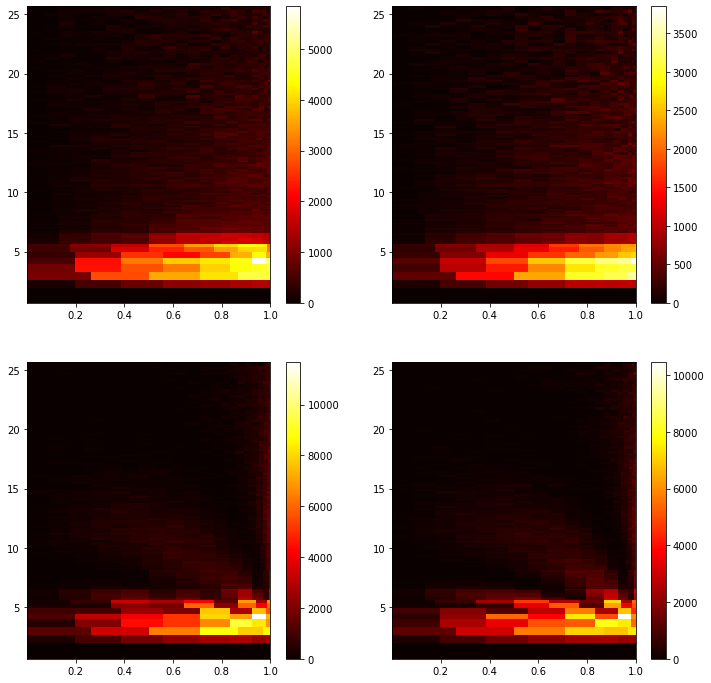

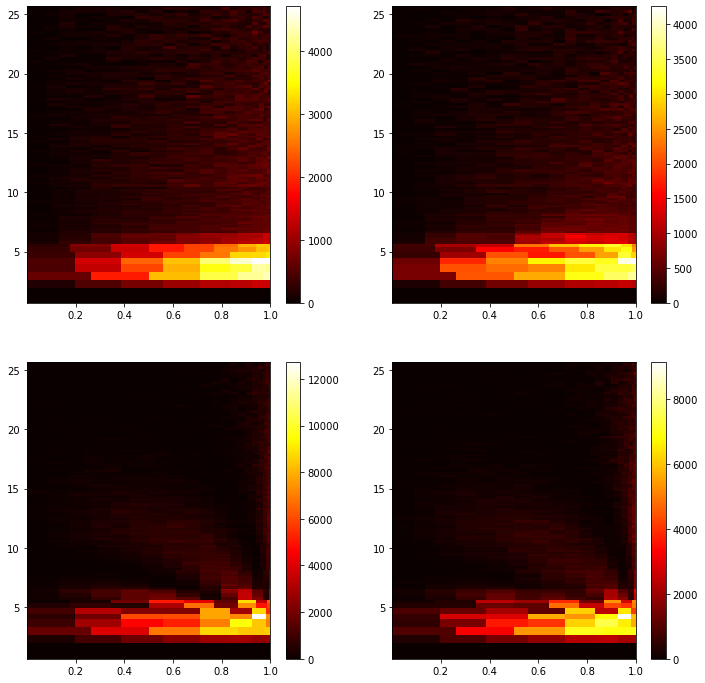

In [11]:
#Data plotting
bins_NO, X, Y, Z_NO = bins(0,len(data))
Plot_all(X,np.cos(Y),Z_NO)
bins_IO, X, Y, Z_IO = bins(1,len(data2))
Plot_all(X,np.cos(Y),Z_IO)

## Введение в вычисление $\sigma(years)$

Зафиксируем полное число зарегистрированных событий $N_{all}^{*}$. "Нарежем" плоскость $cos\theta - E_{\nu} $ на прямоугольники с размерами, равными $1 \sigma$ по соответствующей оси. Будем считать в какой прямоугольник сколько событий попало. Будем считать эти события (событие = случайная величина = число частиц в данном прямоугольнике) независимыми $^{**}$. Попадание частицы в данный прямоугольник - событие Бернулли с вероятностью $p(E_{\nu},cos\theta)$. Тогда полное число частиц в прямоугольнике - биномиально распределённая величина со средним $p N_{all}$ и дисперсией $p (1-p) N_{all}$. При достаточно большом числе событий в прямоугольнике$^{***}$ это распределение станет нормальным с теми же средним и дисперсией. Если мы теперь вычтем из случайной величины её среднее и поделим на корень из дисперсии, то получится нормально распределённая случайная величина с нулевым средним и единичной дисперсией. Взяв сумму квадратов таких величин для всех ячеек по всем ароматам, мы получим величину, распределённую по закону $\chi^2$ с $(N_{all}-1)*N_{flavours} \approx N_{all}*N_{flavours}$ степенями свободы. Таким образом, имея приорное распределение вероятностей, мы можем тестировать имеющийся датасет на соответствие ему по критерию хи-квадрат. 


Наша задача состоит в определении времени, которое потребуется для набора достаточного количества данных, чтобы разделить прямую и обратную иерархию масс - т.е. понять какого размера нужен датасет, чтобы уверенно его отнести к тому или иному приорному распределению. Уточняя далее, мы будем искать вероятность того, что полученное распределение относится к другому типу и вычислять какому количеству sigma это соответствует. 

$^{*}$Эти события получены путём многократного повторения следующей процедуры: 
1. Выбирается случайный угол с равномерным распределением по косинусу (т.е. все значения косинуса угла равновероятны). Равномерное распределение по косинусу как раз соответствует распределению по углам при исходно равномерном распределении в атмосфере.
2. Генерируется атмосферный нейтрино из распределения по энергии и флейворам, измеренным на Super-K. Распределения учитывают угол: для каждого интервала в 0,1 cos theta своё распределение.*
3. Рассчитывается эволюция нейтрино через Землю с учётом профиля её плотности*
4. Учитывается эффективный объём детектора: с вероятностью, пропорциональной $V_{eff}(E_{\nu})$ событие либо записывается, либо нет. 
Условие окончания процедуры: записано $N_{all}$ событий.

$^{**}$ Будем проверять это утверждение следующим образом. Все конечные ответы будем получать по 10 раз на разных выборках, которые будут отличаться тем, что каждое событие будет смещаться по углу и энергии на произвольное значение в пределах своего двумерного гауссова распределения с инструментальной ошибкой и средним в точке самого события. В качестве прогноза будем брать худшее значение и на всякий случай выводить дисперсию (строить все графики sigma(years)). Возможно, эта проверка будет излишней т.к. сходимость оценок и так будет проверяться путём увеличения числа событий. Впрочем, хуже не будет.

$^{***}$ В действительности во многих прямоугольниках всё равно частиц будет очень мало и это предположение выполнено не будет. Мы обсудим этот нюанс далее в тексте.

### Приорное распределение

В действительности приорного распределения мы не знаем, однако можем получть его хорошее приближение с помощью большого датасета, заменяя $p_{i,j}$ на $\dfrac{N_{i,j}}{N_{all}}$. Чтобы получить достаточно большие датасеты для наших целей, будем увеличивать их объёмы и строить график зависимости L2-расстояния между выборочными распределениями. После того, как расстояние прекратит меняться, увеличим датасет ещё вдвое и далее будем пользоваться этим распределением как приорным. График показал, что 1млн событий вполне достаточно.

[  5756   9727  16440  27783  46954  79353 134106 226640 383022 647307
 999967]


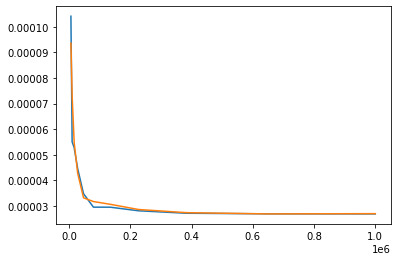

In [14]:
import numpy as np
exponent = np.arange(33,52,2)
power = np.array(1.3**exponent).astype(int)
power = np.append(power,min(len(data),len(data2)))
print(power)
p1 = []
p2 = []
for N in power:
    res = 0
    th, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
    rl, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
    p1.append(L2_dist(th,rl,N))
for N in power:
    res = 0
    th, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
    rl, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
    p2.append(L2_dist(th,rl,N))
plt.plot(power,p1)
plt.plot(power,p2)

In [51]:
chi2.cdf(0.00003,len(bins_IO)-913)

0.0

6711


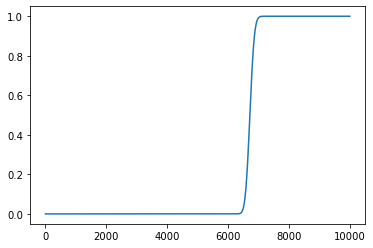

In [53]:
x = np.arange(0,10000,10)
y = chi2.cdf(x,len(bins_IO)-913)
print(len(bins_IO)-913)
plt.plot(x,y)

### P-value & $\chi^2$

Наша конечная цель - график $\sigma(years)$ - точности определения иерархии в з-ти от количества лет, необходимых для измерения. Точность будем определять как максимальное "количество $sigma$", за пределами которых находится вероятность получить данный датасет при "неверной" иерархии масс. Т.е. если верна прямая иерархия, то мы считаем вероятность получить данный датасет при условии, что верна обратная ирерархия, а затем берём соответствующее количество $sigma$ (как это делать, опишем в следующем разделе). Итого нужно научиться получать вероятность реализации данного датасета, при заданном приорном распределении. Как уже было сказано, разобъём плоскость $cos\theta - E_{\nu} $ на прямоугольники и, после всего сказанного во введении, получим величину $\sum$, распределённую по закону $\chi^2$. Если приорное и полученное экспериментально распределение сильно отличаются, то квадраты будут велики и сумма будет сильно уходить от максимума распределения в сторону больших значений. Вероятностью реализации датасета при данном приорном распределении будем называть полную вероятность получить значение нашей величины, распределённой предположительно по $\chi^2$, большую данной в распределении $\chi^2$. Т.е. обозначив плотность распределения $\chi^2$ через $\rho_{\chi^2}(\sum)$ будем иметь $p(\sum) = \int_\sum^\infty \rho_{\chi^2}(x)dx = 1-F_{\chi^2}(\sum)$, где $F_{\chi^2}(x)$ - ф-я распределения $\chi^2$.


$p(\sum)\rightarrow \sigma(years)$
Если вероятность равна $p$, то получить $\sigma$ не сложно. Пусть $G(x)$ - функция распределения Гаусса с центром в нуле и единичной дисперсией. Тогда $\sigma(N) = Abs[G^{-1}(F_{\chi^2}(\sum(N)))]$, где $G^{-1}$ - обратная ф-я к функции $G(x)$. Чтобы получить годы, нужно N разделить на средний поток.


$^*$ Опишем процедуру точнее. Запишем все ячейки по всем ароматам в один массив, индексируемый номерами i. Пусть имеется приорное распределение вероятностей $p_i^k$ (k = 0 - NO, k=1 - IO). Выберем датасет размера $M$ с иерархией $w$ (в ячейке i лежит $N_i$ частиц, $\hat{p}_i := \dfrac{N_i}{M}$). Возьмём приорное распределение вероятностей с иерархией $k$. Рассмотрим случайную величину $Z_i$:
$$ Z_i = \dfrac{N_i-M\cdot p_i^k}{\sqrt{p_i^k\cdot(1-p_i^k)\cdot M\cdot p_i^k}}$$
Т.к. сама N_i распределена по биномиальному закону со средним  $p_i^w M$ и дисперсией $p_i^w\cdot(1-p_i^w)\cdot M\cdot p_i^w$, то, при условии что $k = w$ и при $M p_i \gg 1$, $Z_i$ распределена по Гауссу с нулевым средним и единичной дисперсией. В таком случае мы можем использовать критерий $\chi^2$ для проверки утверждения о том, что $k = w$ (предполагаемая и данная иерархия совпадают). Рассмотрим случайную величину 
$$R = \sum_i Z_i^2 = \sum_i \dfrac{(N_i-M\cdot p_i^k)^2}{p_i^k\cdot(1-p_i^k)\cdot M\cdot p_i^k} = $$
$$= \sum_i \dfrac{(\hat{p}_i-\cdot p_i^k)^2}{p_i^{k\ 2}\cdot(1-p_i^k)}$$

In [15]:
#Запишем приорное распределение
IO_prior = bins_NO/len(data) 
NO_prior = bins_IO/len(data2)

exponent = np.arange(33,52,2)
power2 = np.array(1.3**exponent).astype(int)
power2 = np.append(power2,min(len(data),len(data2)))
print(power2)
p1 = []
p2 = []
p3 = []
p4 = []
#RLS = []
k = 0
for N in power2:
    rl, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
    RLS = RLS + [rl]
    #rl = RLS[k]
    #k += 1
    p1.append(p_value(NO_prior,rl,N))
    p4.append(p_value(IO_prior,rl,N))
    rl, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
    RLS = RLS + [rl]
    #rl = RLS[k]
    #k += 1
    p2.append(p_value(IO_prior,rl,N))
    p3.append(p_value(NO_prior,rl,N))
#a = np.append(a,power2)
plt.plot(power2,p1,'r')
plt.plot(power2,p2,'g')
plt.plot(power2,p3,'b')
plt.plot(power2,p4,'y')

[  5756   9727  16440  27783  46954  79353 134106 226640 383022 647307
 999967]


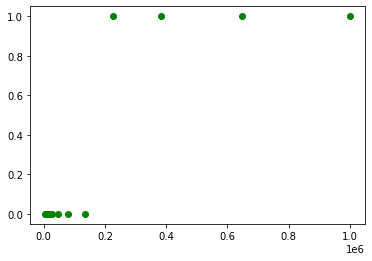

In [70]:
exponent = np.arange(33,52,2)
power2 = np.array(1.3**exponent).astype(int)
power2 = np.append(power2,min(len(data),len(data2)))
print(power2)
p1 = []
p2 = []
p3 = []
p4 = []
#RLS = []
k = 0
for N in power2:
    #rl, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
    #RLS = RLS + [rl]
    rl = RLS[k]
    k += 1
    p1.append(L2_dist(NO_prior,rl,N))
    p4.append(L2_dist(IO_prior,rl,N))
    #rl, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
    #RLS = RLS + [rl]
    rl = RLS[k]
    k += 1
    p2.append(p_value(IO_prior,rl,N))
    p3.append(p_value(NO_prior,rl,N))
#a = np.append(a,power2)
#plt.plot(power2,p1,'r')#Ginv(p1)
plt.plot(power2,p2,'go')
#plt.plot(power2,p3,'b')
#plt.plot(power2,p4,'y')

[170000 173500 177000 180500 184000 187500 191000 194500 198000 201500
 205000 208500 212000 215500 219000 222500 226000 229500 233000 236500
 240000 243500 247000]


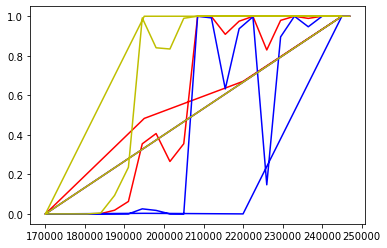

In [124]:
a = power2
power2 = np.arange(170000, 250000, 3500)
print(power2)
'''p1 = []
p2 = []
p3 = []
p4 = []
RLS2 = []'''
k = 0
for N in power2:
    pA = []
    pB = []
    RL = []
    for i in range(5):
        rl, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
        np.random.shuffle(data2)
        pA.append(p_value(NO_prior,rl,N))
        pB.append(p_value(IO_prior,rl,N))
        RL = RL + [rl]
    RL = np.array(RL)
    RLS2 = RLS2 + [RL]
    p1.append(pA)
    p4.append(pB)
    #########
    pA = []
    pB = []
    RL = []
    for i in range(5):
        rl, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
        np.random.shuffle(data)
        pA.append(p_value(IO_prior,rl,N))
        pB.append(p_value(NO_prior,rl,N))
        RL = RL + [rl]
    RL = np.array(RL)
    RLS2 = RLS2 + [RL]
    p2.append(pA)
    p3.append(pB)
power2 = np.append(a,power2)
plt.plot(power2,list(map(lambda y: sum(y)/len(y),p1)),'r')
plt.plot(power2,list(map(min,p1)),'b')
plt.plot(power2,list(map(max,p1)),'y')
#plt.plot(power2,p1,'r')
#plt.plot(power2,p2,'g')
#plt.plot(power2,p3,'b')
#plt.plot(power2,p4,'y')

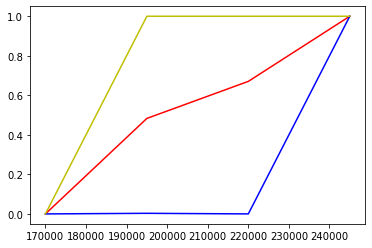

In [122]:
plt.plot(power2,list(map(lambda y: sum(y)/len(y),p1)),'r')
plt.plot(power2,list(map(min,p1)),'b')
plt.plot(power2,list(map(max,p1)),'y')

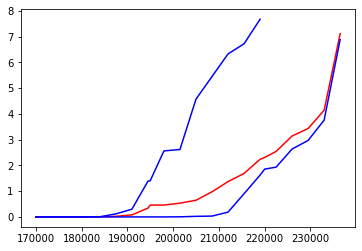

In [139]:
A = power2[power2.argsort()]
B = np.array(list(map(lambda y: sum(y)/len(y),p1)))
B = B[B.argsort()]
plt.plot(A,Ginv(B),'r')
plt.plot(power2[power2.argsort()],Ginv(np.array(list(map(min,p1)))[np.array(list(map(min,p1))).argsort()]),'b')
plt.plot(power2[power2.argsort()],Ginv(np.array(list(map(max,p1)))[np.array(list(map(max,p1))).argsort()]),'b')

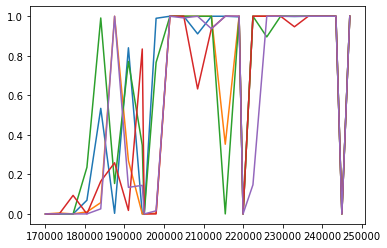

In [157]:
for i in range(5):
    plt.plot(power2,p1[:,i])

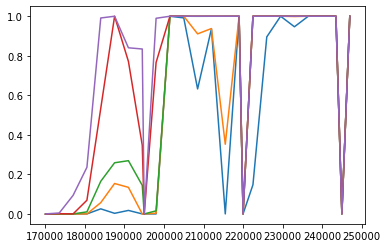

In [163]:
for i in range(5):
    plt.plot(power2,P[:,i])

In [160]:
P = np.zeros(p1.shape)
for i in range(len(p1[:,0])):
    P[i,:] = p1[i,p1[i,:].argsort()]

In [141]:
p1c = p1
p2c = p2
p3c = p3
p4c = p4

In [156]:
power2 = power2[power2.argsort()]

In [153]:

p1 = p1[power2.argsort()]
p2 = np.array(p2)
p2 = p2[power2.argsort()]
p3 = np.array(p3)
p3 = p3[power2.argsort()]
p4 = np.array(p4)
p4 = p4[power2.argsort()]

In [151]:
p1 = np.array(p1)
p1[power2.argsort()]

array([[0.00000000e+00, 0.00000000e+00, 1.84063320e-10, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.32747196e-15,
        0.00000000e+00],
       [1.69864123e-14, 0.00000000e+00, 0.00000000e+00, 6.39290421e-09,
        0.00000000e+00],
       [8.69449845e-10, 1.48586911e-06, 2.60546029e-11, 1.23215882e-11,
        2.48540996e-07],
       [5.47470664e-06, 4.62479452e-03, 1.22118086e-03, 1.40866889e-05,
        5.36518077e-04],
       [3.26608756e-07, 3.21964677e-15, 2.88490292e-05, 9.37662790e-02,
        3.25632854e-10],
       [6.91672344e-02, 1.03727350e-02, 2.35878814e-01, 7.71498421e-11,
        2.17603713e-13],
       [5.34080450e-01, 5.69809595e-02, 9.91208848e-01, 1.65080970e-01,
        2.56520016e-02],
       [3.02940775e-03, 9.99982812e-01, 1.53876357e-01, 2.58759776e-01,
        9.99995247e-01],
       [8.40417774e-01, 2.6929

In [146]:
power2.argsort()

array([ 0,  4,  5,  6,  7,  8,  9, 10, 11,  1, 12, 13, 14, 15, 16, 17, 18,
        2, 19, 20, 21, 22, 23, 24, 25,  3, 26])

In [132]:
power2

array([170000, 195000, 220000, 245000, 170000, 173500, 177000, 180500,
       184000, 187500, 191000, 194500, 198000, 201500, 205000, 208500,
       212000, 215500, 219000, 222500, 226000, 229500, 233000, 236500,
       240000, 243500, 247000])

In [133]:
power2.argsort()

array([ 0,  4,  5,  6,  7,  8,  9, 10, 11,  1, 12, 13, 14, 15, 16, 17, 18,
        2, 19, 20, 21, 22, 23, 24, 25,  3, 26])

In [121]:
x = [[1,2,3],[-5,3,5],[8,-10,11]]
print(map(min,x))

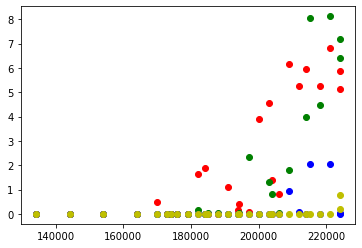

In [74]:
'''a = power2
power2 = np.arange(170000, 226640, 3007)
print(power2)
k = 0
for N in power2:
    rl, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
    RLS2 = RLS2 + [rl]
    #rl = RLS2[k]
    #k += 1
    p1.append(p_value(NO_prior,rl,N))
    p4.append(p_value(IO_prior,rl,N))
    rl, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
    RLS2 = RLS2 + [rl]
    #rl = RLS2[k]
    #k += 1
    p2.append(p_value(IO_prior,rl,N))
    p3.append(p_value(NO_prior,rl,N))
power2 = np.append(a,power2)'''
plt.plot(power2,Ginv(p1),'ro')
plt.plot(power2,Ginv(p2),'go')
plt.plot(power2,Ginv(p3),'bo')
plt.plot(power2,Ginv(p4),'yo')

In [69]:
134106 226640

inf

[  5756   9727  16440  27783  46954  79353 134106 226640 383022 647307
 999967]


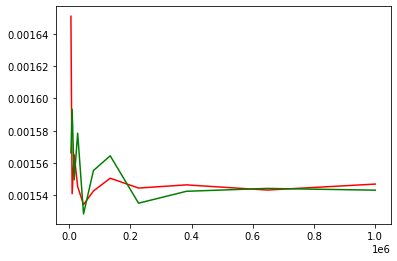

In [50]:
exponent = np.arange(33,52,2)
power2 = np.array(1.3**exponent).astype(int)
power2 = np.append(power2,min(len(data),len(data2)))
print(power2)
p1 = []
p2 = []
p3 = []
p4 = []
#RLS = []
k = 0
for N in power2:
    #rl, X1, Y1, Z1 = np.nan_to_num(bins(1, N))
    #RLS = RLS + [rl]
    rl = RLS[k]
    k += 1
    p1.append(L2_dist(NO_prior,rl,N))
    p4.append(L2_dist(IO_prior,rl,N))
    #rl, X1, Y1, Z1 = np.nan_to_num(bins(0, N))
    #RLS = RLS + [rl]
    rl = RLS[k]
    k += 1
    p2.append(L2_dist(IO_prior,rl,N))
    p3.append(L2_dist(NO_prior,rl,N))
#a = np.append(a,power2)
plt.plot(power2,p1,'r')
plt.plot(power2,p2,'g')
#plt.plot(power2,p3,'b')
#plt.plot(power2,p4,'y')

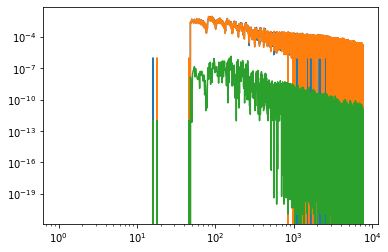

In [47]:
#plt.plot(RLS[len(RLS)-1]/power2[len(power2)-1])
plt.plot(NO_prior)
plt.plot(IO_prior)
plt.plot(np.nan_to_num((IO_prior-NO_prior)**2))
plt.yscale('log')
plt.xscale('log')

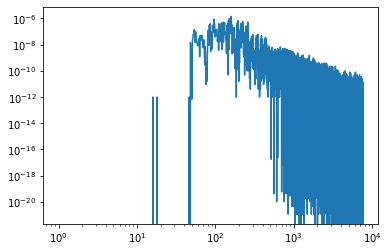

In [43]:
#plt.plot(RLS[len(RLS)-1]/power2[len(power2)-1])
#plt.plot(NO_prior)
plt.plot(np.nan_to_num((IO_prior-NO_prior)**2))
plt.yscale('log')
plt.xscale('log')

In [25]:
p2

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Задачи:

0. Нормировка (N)

1. Учесть эффективный объём из статьи:
при заборе события из файла брать его с вероятностью, пропорциональной эффективному объёму на его энергии. Брать до тех пор, пока не будет достигнуто искомое число событий.
2. Повторить всё то же для других значений расстояния между детекторами
3. Превратить график p(N) в график sigma(years)
4. Подробнее прочитать статью и обозначить какие изменения стоит внести.  Track, intermediate & shower - не надо. А шум?
5. Разобраться с артефактами на сравнении с прежними результатами
6. Учитывать тау-нейтрино?
7. Построить графики чувствительности с новыми погрешностями

8?. Поэкспериментировать с изменением погрешностей - понять, где лучше их оптимизировать
9. Учесть "гауссовость" ошибки

Новые:
10. Перепроверить способ генерации событий (посмотреть статью)
11. Учесть погрешность параметров (статья Смирнова)
12. Малочастичные ячейки